# SVM, Model Comparison & Hyperparameter Tuning Lab

## Overview

In this lab, we build on the classification lab to explore Support Vector Machines, validation curves for model comparison, and automated hyperparameter tuning with Optuna.

**Dataset**: Wine Quality (UCI ML Repository) - Same as classification lab
- **Samples**: ~1,600 red wine samples
- **Features**: 11 physicochemical properties
- **Target**: Quality rating (3-8) -> binary classification (quality >= 6 = "good")
- **Class balance**: ~53% good with the >= 6 cutoff (near-balanced)

**Lab Structure**:
- **Part A**: SVM in scikit-learn (kernels, decision boundaries, regularization)
- **Part B**: Validation curves (training vs validation, metric comparison)
- **Part C**: Optuna introduction (objective functions, optimization, visualization)

## Setup: Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import DecisionBoundaryDisplay

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load wine quality dataset (same as classification lab)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Quality range: {df['quality'].min()}-{df['quality'].max()}")

Dataset shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Quality range: 3-8


In [3]:
# Prepare features and binary target
X = df.drop('quality', axis=1)
y = df['quality']

# Binary target: quality >= 6 is "good"
y_binary = (y >= 6).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution (training):")
print(f"  Not Good (< 6): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"  Good (>= 6):    {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")

Training set: 1279 samples, 11 features
Test set: 320 samples

Class distribution (training):
  Not Good (< 6): 603 (47.1%)
  Good (>= 6):    676 (52.9%)


---
## Part A: SVM in scikit-learn

Support Vector Machines find the hyperplane that maximizes the margin between classes. Different **kernels** allow SVMs to learn non-linear decision boundaries.

### A.1: Fit SVM with Different Kernels

Compare linear, polynomial, and RBF kernels on the wine quality data. Each kernel transforms the feature space differently.

In [4]:
# TODO: Fit SVM with different kernels and compare accuracy
# Hint: Use Pipeline with StandardScaler + SVC for each kernel
# Kernels to try: 'linear', 'poly', 'rbf'

kernels = ['linear', 'poly', 'rbf']
results = {}

for kernel in kernels:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[kernel] = acc
    print(f"{kernel} kernel accuracy: {acc}")

best_kernel = max(results, key=results.get)
print(f"\nBest kernel: {best_kernel} (Accuracy: {results[best_kernel]:.4f})")

linear kernel accuracy: 0.728125
poly kernel accuracy: 0.765625
rbf kernel accuracy: 0.771875

Best kernel: rbf (Accuracy: 0.7719)


### A.2: Decision Boundaries on Wine Data (Alcohol vs Sulphates)

To make a concrete plot in 2D, we look at two real features. We use alcohol vs sulphates because it gives a clearer slice for illustration. The boundary and accuracy here are for the 2-feature slice only, not the full 11D feature space or a model-comparison result.

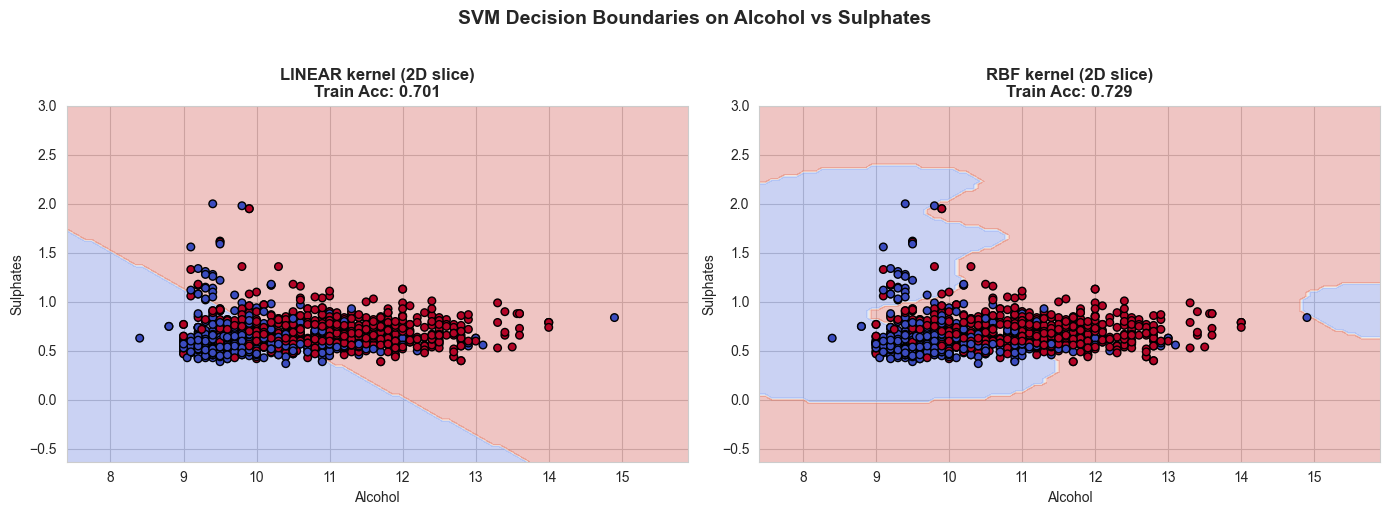

Note: This boundary is for a 2-feature slice, not the full 11D space.


In [5]:
feature_x = 'alcohol'
feature_y = 'sulphates'

X_train_2d = X_train[[feature_x, feature_y]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, kernel in zip(axes, ['linear', 'rbf']):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, random_state=42))
    ])
    pipeline.fit(X_train_2d, y_train)

    DecisionBoundaryDisplay.from_estimator(
        pipeline, X_train_2d, ax=ax, response_method='predict',
        cmap='coolwarm', alpha=0.3
    )
    ax.scatter(
        X_train_2d[feature_x], X_train_2d[feature_y],
        c=y_train, cmap='coolwarm', edgecolors='black', s=30
    )
    acc = pipeline.score(X_train_2d, y_train)
    ax.set_title(f'{kernel.upper()} kernel (2D slice)\nTrain Acc: {acc:.3f}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature_x.title())
    ax.set_ylabel(feature_y.title())

plt.suptitle('SVM Decision Boundaries on Alcohol vs Sulphates', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Note: This boundary is for a 2-feature slice, not the full 11D space.")

### A.3: Support Vectors on the 2D Feature Slice

Support vectors are the points closest to the boundary. We highlight them on the alcohol vs sulphates slice; counts and accuracy are for this 2D view only.

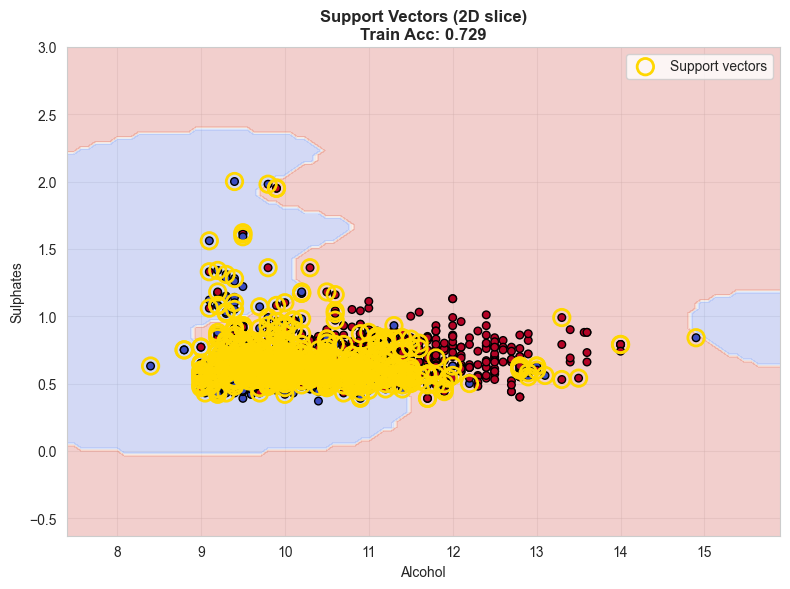

Number of support vectors: 765
Note: Support vectors are defined in this 2D feature slice.


In [6]:
svc_sv = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])
svc_sv.fit(X_train_2d, y_train)

fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(
    svc_sv, X_train_2d, ax=ax, response_method='predict',
    cmap='coolwarm', alpha=0.25
 )
ax.scatter(
    X_train_2d[feature_x], X_train_2d[feature_y],
    c=y_train, cmap='coolwarm', edgecolors='black', s=30
 )

sv_idx = svc_sv.named_steps['svc'].support_
ax.scatter(
    X_train_2d.iloc[sv_idx][feature_x], X_train_2d.iloc[sv_idx][feature_y],
    s=140, facecolors='none', edgecolors='gold', linewidths=2,
    label='Support vectors'
 )

acc = svc_sv.score(X_train_2d, y_train)
ax.set_title(f'Support Vectors (2D slice)\nTrain Acc: {acc:.3f}', fontsize=12, fontweight='bold')
ax.set_xlabel(feature_x.title())
ax.set_ylabel(feature_y.title())
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number of support vectors: {len(sv_idx)}")
print("Note: Support vectors are defined in this 2D feature slice.")

---
## Part B: Validation Curves

Validation curves show how a hyperparameter affects both training and validation performance, helping us detect **underfitting** (both scores low) and **overfitting** (training high, validation low).

### B.1: Validation Curve for C

Use `sklearn.model_selection.validation_curve` to sweep over C values (log scale) and plot training vs validation scores with error bands. The gap between the curves signals underfitting vs overfitting.

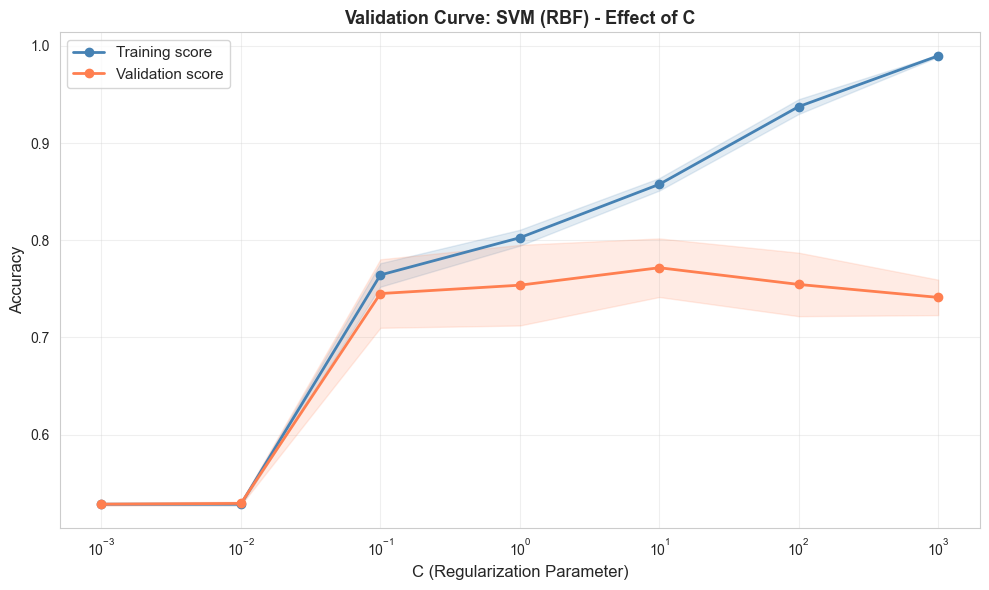

Best C: 10.0000 (Validation Accuracy: 0.7717)

Small C = underfitting (both scores low)
Large C = potential overfitting (training high, validation plateaus/drops)


In [9]:
# TODO: Use validation_curve to vary C from 0.001 to 1000 (log scale, 7 values)
# Hint: C_range = np.logspace(-3, 3, 7)
# Hint: validation_curve(Pipeline([...]), X_train, y_train, param_name='svc__C', param_range=C_range, cv=5, scoring='accuracy')
C_range = np.logspace(-3, 3, 7)
svm_pipeline = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf"))])
train_scores, val_scores = validation_curve(svm_pipeline,
    X_train,
    y_train,
    param_name="svc__C",
    param_range=C_range,
    cv=5,
    scoring="accuracy")


# Compute means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(C_range, train_mean, 'o-', color='steelblue', label='Training score', linewidth=2)
ax.fill_between(C_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='steelblue')
ax.semilogx(C_range, val_mean, 'o-', color='coral', label='Validation score', linewidth=2)
ax.fill_between(C_range, val_mean - val_std, val_mean + val_std, alpha=0.15, color='coral')

ax.set_xlabel('C (Regularization Parameter)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Validation Curve: SVM (RBF) - Effect of C', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_idx = np.argmax(val_mean)
print(f"Best C: {C_range[best_idx]:.4f} (Validation Accuracy: {val_mean[best_idx]:.4f})")
print(f"\nSmall C = underfitting (both scores low)")
print(f"Large C = potential overfitting (training high, validation plateaus/drops)")

### B.2: Compare Metrics on Class Imbalance

With the >= 6 cutoff, classes are closer to balanced, but accuracy can still hide performance on the positive class. We compare validation curves using **accuracy** vs **F1-score** (for the "good" class); expect the curves to be closer than in a more imbalanced setup.

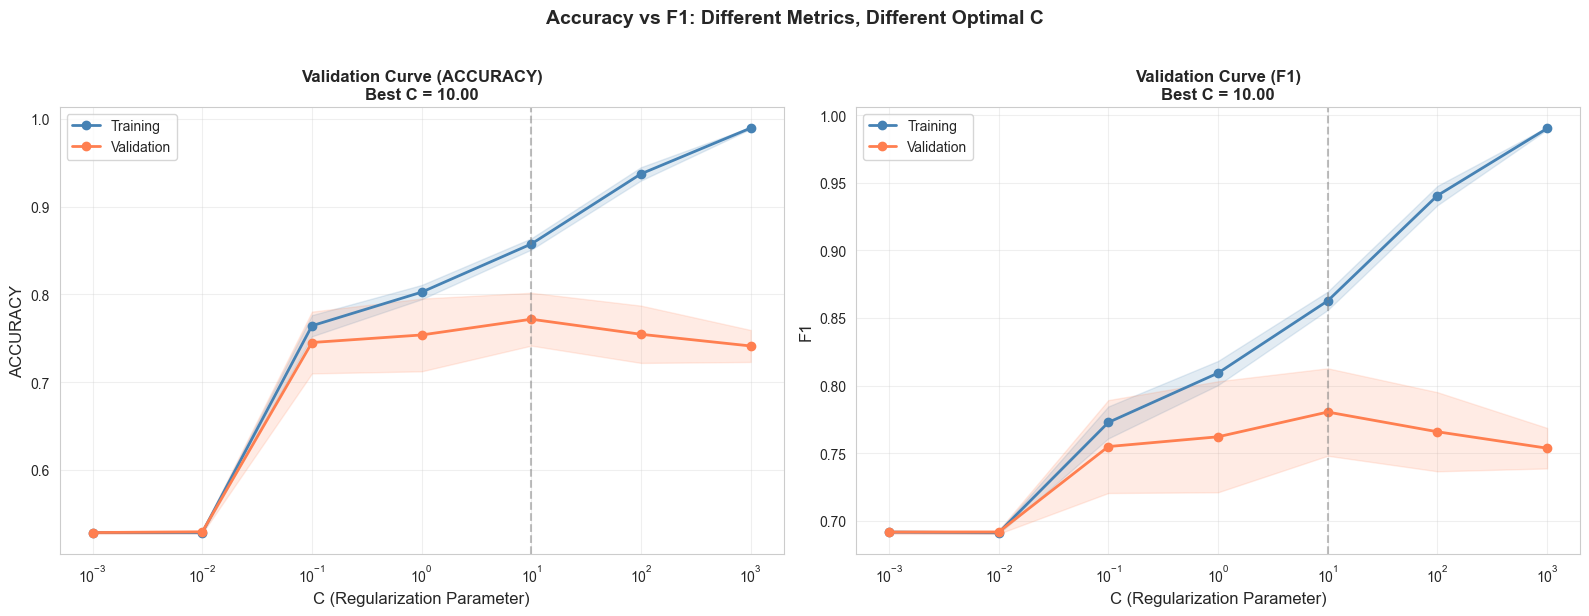

Key insight: Even with near-balanced classes, different metrics may suggest different optimal C.
             F1-score emphasizes performance on the positive class ('good' wines).


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, scoring in zip(axes, ['accuracy', 'f1']):
    train_scores, val_scores = validation_curve(
        svm_pipeline, X_train, y_train,
        param_name='svc__C', param_range=C_range,
        cv=5, scoring=scoring
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    ax.semilogx(C_range, train_mean, 'o-', color='steelblue', label='Training', linewidth=2)
    ax.fill_between(C_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='steelblue')
    ax.semilogx(C_range, val_mean, 'o-', color='coral', label='Validation', linewidth=2)
    ax.fill_between(C_range, val_mean - val_std, val_mean + val_std, alpha=0.15, color='coral')
    
    best_idx = np.argmax(val_mean)
    ax.axvline(x=C_range[best_idx], color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('C (Regularization Parameter)', fontsize=12)
    ax.set_ylabel(scoring.upper(), fontsize=12)
    ax.set_title(f'Validation Curve ({scoring.upper()})\nBest C = {C_range[best_idx]:.2f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Accuracy vs F1: Different Metrics, Different Optimal C', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Key insight: Even with near-balanced classes, different metrics may suggest different optimal C.")
print("             F1-score emphasizes performance on the positive class ('good' wines).")

---
## Part C: Optuna Introduction

Manual hyperparameter search is tedious. **Optuna** is a modern hyperparameter optimization framework that uses intelligent search strategies (e.g., Tree-structured Parzen Estimators) to find good hyperparameters efficiently.

In [11]:
import optuna
from optuna.samplers import TPESampler, RandomSampler, GridSampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_contour,
    plot_parallel_coordinate,
    plot_edf,
 )

# Suppress Optuna's verbose logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Optuna version: {optuna.__version__}")
print("Optuna imported successfully!")

Optuna version: 4.7.0
Optuna imported successfully!


### C.1: Define an Objective Function

Optuna works by repeatedly calling an **objective function** that:
1. **Suggests** hyperparameter values from defined ranges
2. **Trains** a model with those values
3. **Returns** a score to optimize

In [13]:
# TODO: Define an objective function for Optuna
# Hint: Use trial.suggest_float('C', 0.01, 100, log=True) for C
# Hint: Use trial.suggest_float('gamma', 1e-4, 1, log=True) for gamma
# Hint: Use trial.suggest_categorical('kernel', ['rbf', 'poly']) for kernel
# Hint: Use cross_val_score with 5-fold CV and return mean accuracy

def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, C=C, gamma=gamma, random_state=42))
    ])
    acc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    return acc.mean()


print("Objective function defined.")
print("It suggests C (0.01-100), gamma (1e-4 to 1), and kernel (rbf/poly).")
print("Returns mean 5-fold CV accuracy.")

Objective function defined.
It suggests C (0.01-100), gamma (1e-4 to 1), and kernel (rbf/poly).
Returns mean 5-fold CV accuracy.


### C.2: Optimization Options (TPE, Random, Grid)

Optuna supports multiple search strategies through **samplers**. We compare:
- **TPE (default)**: model-based search (often faster improvements)
- **Random search**: baseline that ignores past trials
- **Grid search**: exhaustive search over a small, discrete grid

In [14]:
n_trials = 30

tpe_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='TPE',
)
tpe_study.optimize(objective, n_trials=n_trials)

random_study = optuna.create_study(
    direction='maximize',
    sampler=RandomSampler(seed=42),
    study_name='Random',
)
random_study.optimize(objective, n_trials=n_trials)

grid_space = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
}

def objective_grid(trial):
    C = trial.suggest_categorical('C', grid_space['C'])
    gamma = trial.suggest_categorical('gamma', grid_space['gamma'])
    kernel = 'rbf'

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, C=C, gamma=gamma, random_state=42))
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

grid_study = optuna.create_study(
    direction='maximize',
    sampler=GridSampler(grid_space),
    study_name='Grid',
)
grid_study.optimize(objective_grid)

def report_best(study):
    print(f"{study.study_name}: best accuracy = {study.best_trial.value:.4f}")
    for key, value in study.best_trial.params.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

print("\nBest results by strategy:")
report_best(tpe_study)
report_best(random_study)
report_best(grid_study)


Best results by strategy:
TPE: best accuracy = 0.7530
  C: 16.382657
  gamma: 0.023939
  kernel: rbf
Random: best accuracy = 0.7592
  C: 28.340904
  gamma: 0.031131
  kernel: rbf
Grid: best accuracy = 0.7709
  C: 10
  gamma: 0.100000


In [15]:
# Demo: Evaluate best params on test set (TPE study)
best_params = tpe_study.best_trial.params
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        kernel=best_params['kernel'],
        C=best_params['C'],
        gamma=best_params['gamma'],
        random_state=42
    ))
])
best_pipeline.fit(X_train, y_train)
test_acc = best_pipeline.score(X_test, y_test)

print(f"Test accuracy with Optuna TPE best params: {test_acc:.4f}")
print(f"\nCompare with default SVC: fit and evaluate with default hyperparameters.")

default_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])
default_pipeline.fit(X_train, y_train)
default_acc = default_pipeline.score(X_test, y_test)
print(f"Test accuracy with default SVC:             {default_acc:.4f}")
print(f"Improvement: {test_acc - default_acc:+.4f}")

Test accuracy with Optuna TPE best params: 0.7719

Compare with default SVC: fit and evaluate with default hyperparameters.
Test accuracy with default SVC:             0.7719
Improvement: +0.0000


### C.3: Visualization

We use Optuna's plotting tools to understand the search. The plots below use the TPE study, and the EDF compares TPE vs random vs grid.

<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

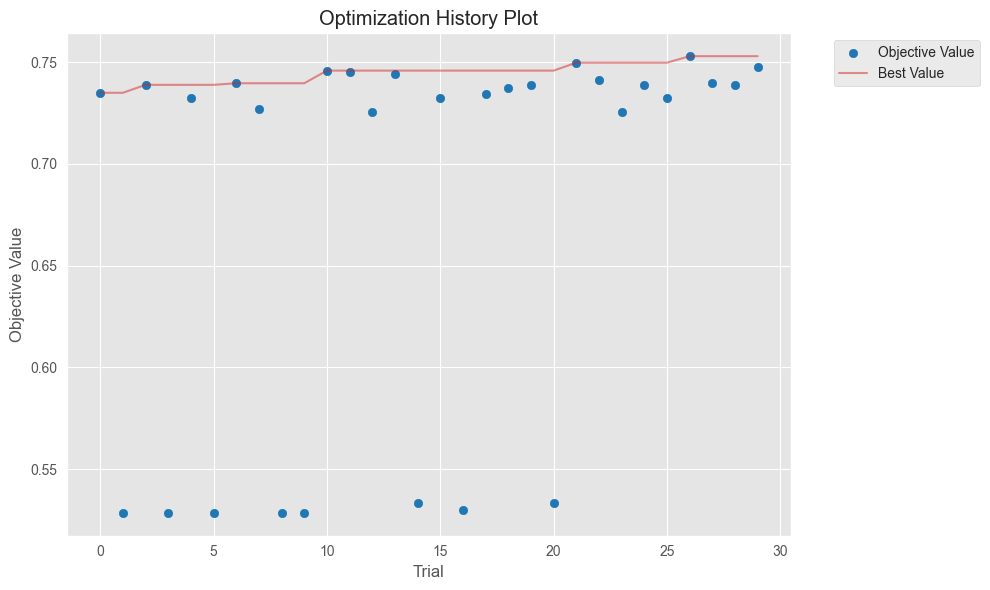

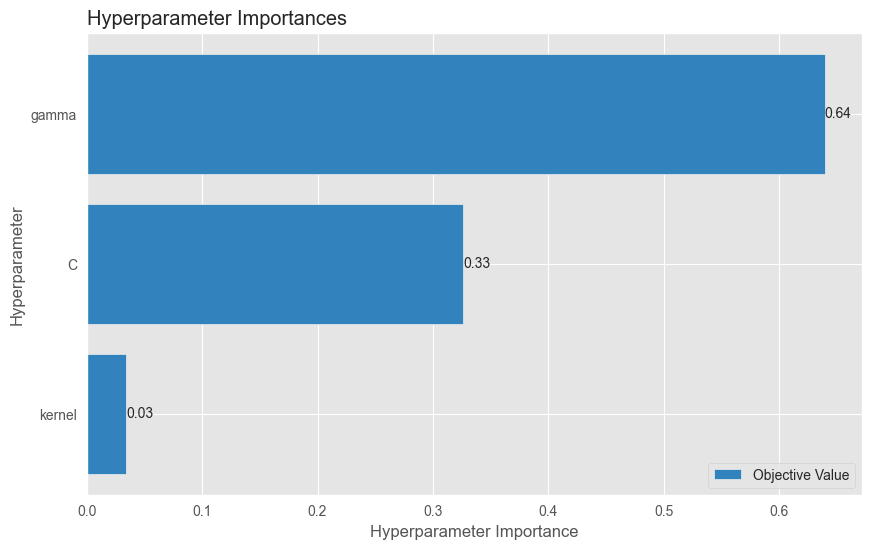

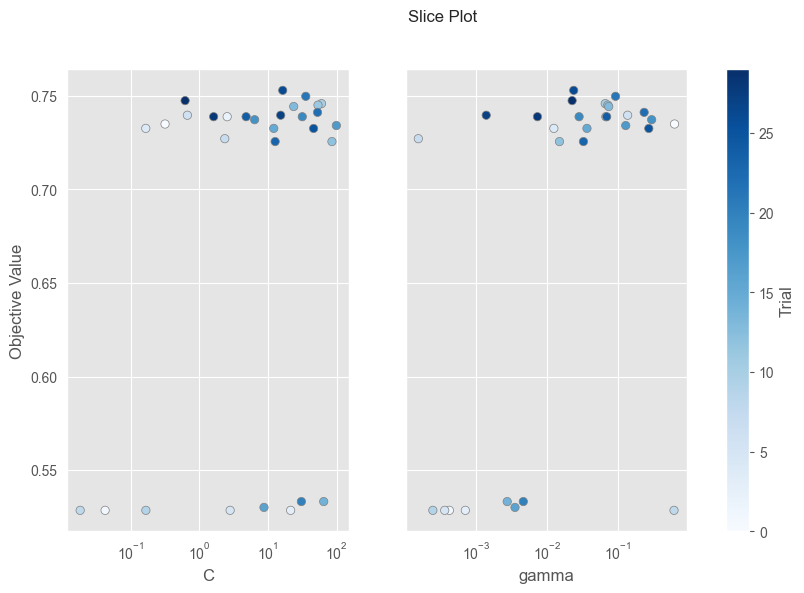

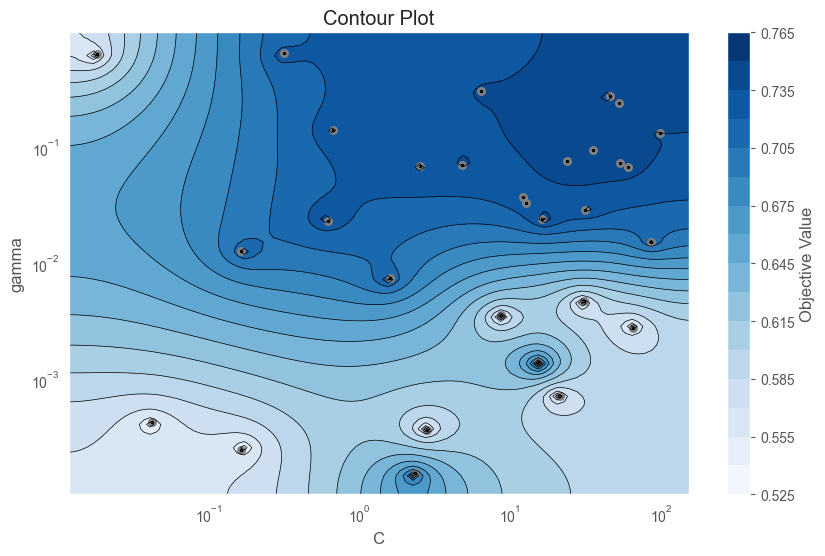

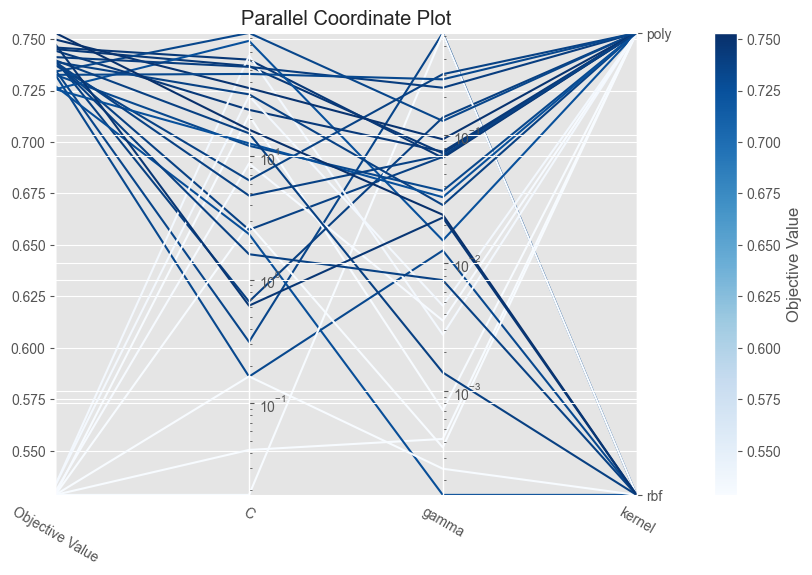

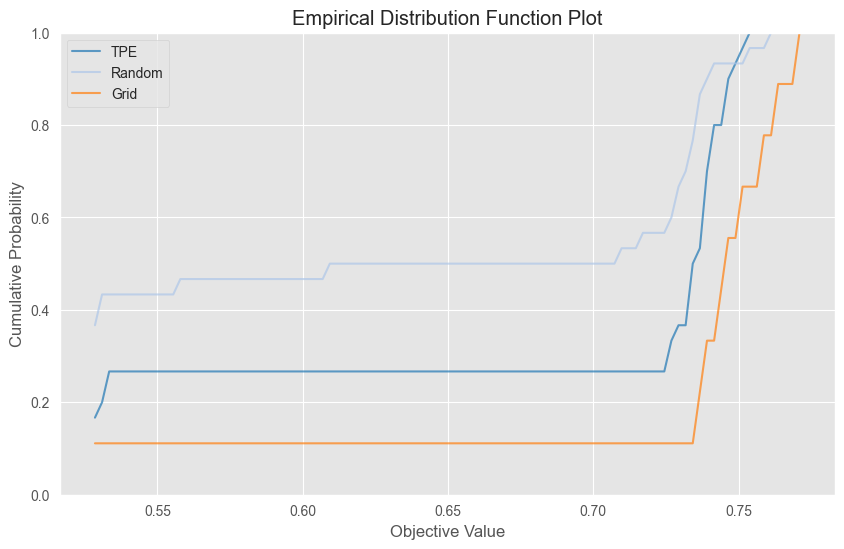

In [ ]:
# TODO: Plot optimization diagnostics (TPE) and compare strategies

# Optimization history -- most useful
plot_optimization_history(tpe_study)

# Parameter importances -- can tell importance of params
plot_param_importances(tpe_study)

# Slice plot for key params
plot_slice(tpe_study, params=["C", "gamma"])

# Contour plot for interaction -- not that useful but looks cool
plot_contour(tpe_study, params=["C", "gamma"])

# Parallel coordinate plot for all params -- niche but could be useful
plot_parallel_coordinate(tpe_study, params=["C", "gamma", "kernel"])

# EDF plot comparing all strategies
plot_edf([tpe_study, random_study, grid_study])